# How to automate medical diagnosis using Amazon SageMaker

Detecting cancer cells by analyzing medical images using computer vision with Amazon SageMaker


## Setup

In [ ]:
# install tree command (helpful in printing folder structures)
!apt-get install tree

# setup AWS cli
!mkdir -p ~/.aws && cp /content/drive/MyDrive/AWS/d01_admin/* ~/.aws
!chmod 600 ~/.aws/credentials
!pip install awscli

# install boto3 and sagemaker
!pip install boto3
!pip install sagemaker

# install dependencies
!pip install pyathena
!pip install awswrangler
!pip install smclarify
!pip install sagemaker-experiments
!pip install sagemaker-tensorflow
!pip install smclarify
!pip install stepfunctions
!pip install imbalanced-learn

# install nlp libs
!pip install transformers

In [12]:
# imports
import boto3
import sagemaker
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import io
import os
import sys
import time
import datetime
import string
import json
import csv
import pathlib
import h5py
import zipfile
from tqdm.auto import tqdm

import awswrangler as wr

from scipy.sparse import csr_matrix, hstack, save_npz, load_npz
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import sagemaker.amazon.common as smac
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import JSONSerializer
from sagemaker.multidatamodel import MultiDataModel
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.lineage import context, artifact, association, action
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.xgboost.estimator import XGBoost

In [2]:
# global variables
role = "sagemakerRole"
prefix = "sagemaker-exp12061030"
training_instance_type = "ml.m5.xlarge"

In [6]:
# setup sagemaker session
sess = sagemaker.Session()
bucket = sess.default_bucket()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
role_arn = "arn:aws:iam::{}:role/{}".format(account_id, role)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3_client = boto3.Session().client(service_name="s3", region_name=region)
runtime = boto3.Session().client(service_name='runtime.sagemaker')
runtime_sm_client = boto3.client('sagemaker-runtime')
boto_session = boto3.Session(region_name=region)
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sm
)

## Data Ingest

The dataset for this demo comes from the [Camelyon16 Challenge](https://camelyon16.grand-challenge.org/) made available under the CC0 licencse. The raw data provided by the challenge has been processed into 96x96 pixel tiles by [Bas Veeling](https://github.com/basveeling/pcam) and also made available under the CC0 license. For detailed information on each dataset please see the papers below:
* Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. [doi:jama.2017.14585](https://doi.org/10.1001/jama.2017.14585)
* B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". [arXiv:1806.03962](http://arxiv.org/abs/1806.03962)

The tiled dataset from Bas Veeling is over 6GB of data. In order to easily run this demo, the dataset has been pruned to the first 14,000 images of the tiled dataset.

In [5]:
# check if directory exists
if not os.path.isdir("data"):
    os.mkdir("data")

# download zip file from public s3 bucket
!wget -q --show-progress -P data https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/pcam/medical_images.zip

medical_images.zip  100%[===================>] 369.16M  56.2MB/s    in 6.3s    


In [5]:
with zipfile.ZipFile("data/medical_images.zip") as zf:
    zf.extractall()
with open("data/camelyon16_tiles.h5", "rb") as hf:
    f = h5py.File(hf, "r")

    X = f["x"][()]
    y = f["y"][()]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (14000, 96, 96, 3)
Shape of y: (14000,)


In [7]:
# write to session s3 bucket
s3_client.upload_file("data/medical_images.zip", bucket, f"data/medical_images.zip")

In [8]:
# delete local copy
if os.path.exists("data/medical_images.zip"):
    os.remove("data/medical_images.zip")
else:
    print("The file does not exist")

## Data Prepare

View Sample Images from Dataset

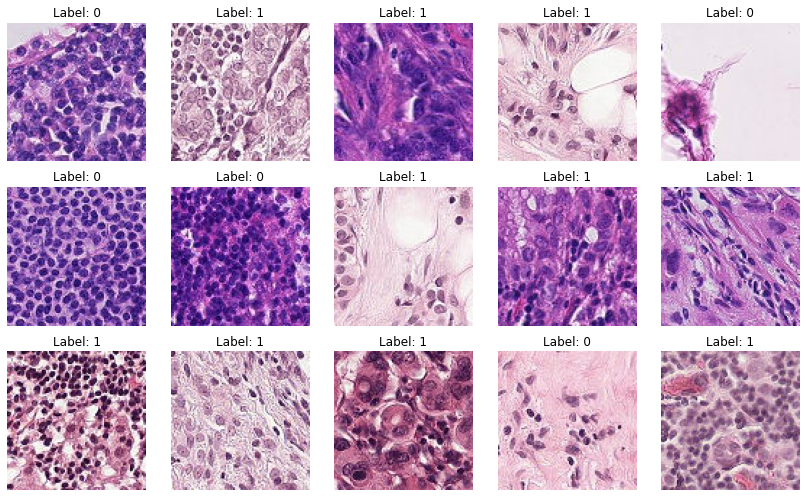

In [9]:
def preview_images(X, y, n, cols):
    sample_images = X[:n]
    sample_labels = y[:n]

    rows = int(np.ceil(n / cols))
    fig, axs = plt.subplots(rows, cols, figsize=(11.5, 7))

    for i, ax in enumerate(axs.flatten()):
        image = sample_images[i]
        label = sample_labels[i]
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(f"Label: {label}")

    plt.tight_layout()


preview_images(X, y, 15, 5)

Shuffle and Split Dataset

In [10]:
X_numpy = X[:]
y_numpy = y[:]

X_train, X_test, y_train, y_test = train_test_split(
    X_numpy, y_numpy, test_size=1000, random_state=0
)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=2000, random_state=1)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(11000, 96, 96, 3)
(2000, 96, 96, 3)
(1000, 96, 96, 3)


Convert Splits to RecordIO Format

In [13]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [15]:
!pip install mxnet-cu110

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 327.3 MB 6.0 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [16]:
def write_to_recordio(X: np.ndarray, y: np.ndarray, prefix: str):
    import mxnet as mx
    record = mx.recordio.MXIndexedRecordIO(idx_path=f"{prefix}.idx", uri=f"{prefix}.rec", flag="w")
    for idx, arr in enumerate(tqdm(X)):
        header = mx.recordio.IRHeader(0, y[idx], idx, 0)
        s = mx.recordio.pack_img(
            header,
            arr,
            quality=95,
            img_fmt=".jpg",
        )
        record.write_idx(idx, s)
    record.close()

In [17]:
write_to_recordio(X_train, y_train, prefix="data/train")
write_to_recordio(X_val, y_val, prefix="data/val")
write_to_recordio(X_test, y_test, prefix="data/test")

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Upload Data Splits to S3

In [18]:
s3_client.upload_file("data/train.rec", bucket, f"{prefix}/data/train/train.rec")
s3_client.upload_file("data/val.rec", bucket, f"{prefix}/data/val/val.rec")
s3_client.upload_file("data/test.rec", bucket, f"{prefix}/data/test/test.rec")

## Model Train

Configure the Estimator

In [30]:
training_image = sagemaker.image_uris.retrieve("image-classification", region)
num_training_samples = X_train.shape[0]
num_classes = len(np.unique(y_train))

hyperparameters = {
    "num_layers": 18,
    "use_pretrained_model": 1,
    "augmentation_type": "crop_color_transform",
    "image_shape": "3,96,96",
    "num_classes": num_classes,
    "num_training_samples": num_training_samples,
    "mini_batch_size": 64,
    "epochs": 5,
    "learning_rate": 0.01,
    "precision_dtype": "float32",
}

estimator_config = {
    "hyperparameters": hyperparameters,
    "image_uri": training_image,
    "role": role,
    "instance_count": 1,
    "instance_type": "ml.p3.2xlarge",
    "volume_size": 100,
    "max_run": 360000,
    "output_path": f"s3://{bucket}/{prefix}/training_jobs",
    "use_spot_instances": True,
    "max_run": 600,
    "max_wait": 1200
}

image_classifier = sagemaker.estimator.Estimator(**estimator_config)

Configure the Hyperparameter Tuner

*Although we would prefer to tune for recall, the current HyperparameterTuner implementation for Image Classification only supports validation accuracy.*

In [31]:
hyperparameter_ranges = {
    "mini_batch_size": sagemaker.parameter.CategoricalParameter([16, 32, 64]),
    "learning_rate": sagemaker.parameter.CategoricalParameter([0.001, 0.01]),
}

hyperparameter_tuner = sagemaker.tuner.HyperparameterTuner(
    estimator=image_classifier,
    objective_metric_name="validation:accuracy",
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=2,
    max_parallel_jobs=1,
    base_tuning_job_name=prefix,
)

Define the Data Channels

In [32]:
train_input = sagemaker.inputs.TrainingInput(
    s3_data=f"s3://{bucket}/{prefix}/data/train",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
    input_mode="Pipe",
)

val_input = sagemaker.inputs.TrainingInput(
    s3_data=f"s3://{bucket}/{prefix}/data/val",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
    input_mode="Pipe",
)

data_channels = {"train": train_input, "validation": val_input}

Run Hyperparameter Tuning Jobs

In [ ]:
hyperparameter_tuner.fit(inputs=data_channels)
tuning_job_name = hyperparameter_tuner.describe().get("HyperParameterTuningJobName")
tuning_job_name

Examine Results

In [ ]:
results = sagemaker.analytics.HyperparameterTuningJobAnalytics(tuning_job_name)
results_df = results.dataframe()
results_df

In [ ]:
best_training_job_summary = results.description()["BestTrainingJob"]
best_training_job_name = best_training_job_summary["TrainingJobName"]
best_training_job_name